In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from math import nan

import sys
import scipy.stats as stats
import matplotlib as mpl
import matplotlib.patches as mpatches

plt.rc('font', family='Arial')

import warnings
warnings.filterwarnings('ignore')

from qtrendutils import mapplot_utils as mymaps
from matplotlib.patches import Rectangle

In [2]:
plotpath="/project/cas/islas/python_plots/qtrend_paper/figures/supplemental/"

In [3]:
landfrac = xr.open_dataset("/project/cas/islas/cesm2le/fx/LANDFRAC_LENS2.nc")
landfrac = landfrac.landfrac
landfrac = landfrac.where(landfrac > 0, nan)

### Observation data

In [4]:
datpath="/project/cas/islas/python_savs/qtrend_paper/DATA_SORT/1980_2020_trends/"
era5vp_map = xr.open_dataset(datpath+'vptrends_ERA5.nc')
era5vp_map['lon'] = landfrac.lon ; era5vp_map['lat'] = landfrac.lat
gpcp_map = xr.open_dataset(datpath+'prtrends_GPCP.nc')
gpcp_map['lon'] = landfrac.lon ; gpcp_map['lat'] = landfrac.lat
gpcc_map = xr.open_dataset(datpath+'prtrends_GPCC.nc')
gpcc_map['lon'] = landfrac.lon ; gpcc_map['lat'] = landfrac.lat
cruts_map = xr.open_dataset(datpath+'prtrends_CRUTS.nc')
cruts_map['lon'] = landfrac.lon ; cruts_map['lat'] = landfrac.lat

In [5]:
pet_tc = xr.open_dataset("/project/cas/islas/python_savs/qtrend_paper/DATA_SORT/Aridity_Index/PET_Terraclim_1980_2020.nc")
pet_tc = pet_tc.mean('time')
ppt_tc = xr.open_dataset("/project/cas/islas/python_savs/qtrend_paper/DATA_SORT/Aridity_Index/PPT_Terraclim_1980_2020.nc")
ppt_tc = ppt_tc.mean('time')
aridity = ppt_tc.ppt / pet_tc.pet
aridity['lon'] = landfrac.lon ; aridity['lat'] = landfrac.lat

In [6]:
aridmask = landfrac.where( (aridity > 0.05) & (aridity < 0.5), nan)
humidmask = landfrac.where( (aridity >= 0.5), nan)
hyperaridmask = landfrac.where( (aridity <= 0.05), nan)

#aridmask = aridmask.where( np.abs(aridmask.lat) < 70, nan)
#humidmask = humidmask.where( np.abs(humidmask.lat) < 70, nan)
#hyperaridmask = hyperaridmask.where( np.abs(hyperaridmask.lat) < 70, nan)
aridmask = aridmask.where( aridmask.lat > -60, nan)
humidmask = humidmask.where( humidmask.lat > -60, nan)
hyperaridmask = hyperaridmask.where(hyperaridmask.lat > -60, nan)

### Model based data

In [7]:
cmip6vp_map = xr.open_dataset('/project/cas/islas/python_savs/qtrend_paper/DATA_SORT/1980_2020_trends/vptrends_CMIP6.nc')
cmip6vp_map['lon'] = landfrac.lon ; cmip6vp_map['lat'] = landfrac.lat
cmip6vp_map = cmip6vp_map.vp

cmip6pr_map = xr.open_dataset(datpath+'prtrends_CMIP6.nc')*86400.
cmip6pr_map['lon'] = landfrac.lon ; cmip6pr_map['lat'] = landfrac.lat
cmip6pr_map = cmip6pr_map.pr

lens2vp_map = xr.open_dataset("/project/cas/islas/python_savs/watervapor/DATA_SORT/LENS2/1980_2020_trends/VPtrends_annualmean_lens2_1980_2020.nc")
lens2vp_map['lon'] = landfrac.lon ; lens2vp_map['lat'] = landfrac.lat
lens2pr_map = xr.open_dataset("/project/cas/islas/python_savs/watervapor/DATA_SORT/LENS2/1980_2020_trends/PRECIPtrends_annualmean_lens2_1980_2020.nc")
lens2pr_map['lon'] = landfrac.lon ; lens2pr_map['lat'] = landfrac.lat

In [8]:
cmip6vp_map_1mem = cmip6vp_map.isel(member=0)
cmip6pr_map_1mem = cmip6pr_map.isel(member=0)

cmip6vp_map = cmip6vp_map.stack(z=['model','member'])
cmip6pr_map = cmip6pr_map.stack(z=['model','member'])

testpoint = cmip6vp_map.sel(lon=180, lat=0, method='nearest')

cmip6vp_map = cmip6vp_map.where( ~np.isnan(testpoint), drop=True )
cmip6pr_map = cmip6pr_map.where( ~np.isnan(testpoint), drop=True )

### Set up the joint pdf

In [9]:
def setupjointpdf( vpdata, svpdata, weights ):
    X, Y = np.mgrid[-1.500:1.525:122j, -2.5:5:76j] # probabilities represent per (0.025 precip, 0.1 vp)
    positions = np.vstack([X.ravel(), Y.ravel()])
    
    xplot = vpdata.flatten()
    yplot = svpdata.flatten()
    inputdata = np.vstack([xplot, yplot])
    kernel = stats.gaussian_kde(inputdata, weights=weights)
    Z = np.reshape(kernel(positions).T, X.shape)
    Z = np.moveaxis(Z, 1, 0)
    Xout = X[:,0] ; Yout = Y[0,:]
    return Z, Xout, Yout

In [10]:
X, Y = np.mgrid[-1.500:1.525:122j, -2.5:5:76j]

In [11]:
print(X[1,0]-X[0,0])

0.02499999999999991


In [12]:
print(Y[0,1]-Y[0,0])

0.10000000000000009


In [13]:
cmip6vp_arid = cmip6vp_map_1mem*aridmask ; cmip6pr_arid = cmip6pr_map_1mem*aridmask
cmip6vp_arid = cmip6vp_arid.stack(z=['lon','lat']).dropna('z')
cmip6pr_arid = cmip6pr_arid.stack(z=['lon','lat']).dropna('z')

cmip6vp_arid_allmem = cmip6vp_map*aridmask ; cmip6pr_arid_allmem = cmip6pr_map*aridmask
cmip6vp_arid_allmem = cmip6vp_arid_allmem.stack(loc=['lon','lat']).dropna('loc')
cmip6pr_arid_allmem = cmip6pr_arid_allmem.stack(loc=['lon','lat']).dropna('loc')

In [14]:
lens2vp_arid = lens2vp_map*aridmask ; lens2pr_arid = lens2pr_map*aridmask
lens2vp_arid = lens2vp_arid.stack(z=['lon','lat']).dropna('z')
lens2pr_arid = lens2pr_arid.stack(z=['lon','lat']).dropna('z')

In [15]:
cmip6vp_arid = cmip6vp_map_1mem*aridmask ; cmip6pr_arid = cmip6pr_map_1mem*aridmask
cmip6vp_arid = cmip6vp_arid.stack(z=['lon','lat']).dropna('z')
cmip6pr_arid = cmip6pr_arid.stack(z=['lon','lat']).dropna('z')

#----basing which grid points to drop on GPCC since it has a few extra NaN's around the coast
gpcc_arid = gpcc_map*aridmask 
gpcc_arid = gpcc_arid.stack(z=['lon','lat'])#.dropna('z')

cruts_arid = cruts_map*aridmask
cruts_arid = cruts_arid.stack(z=['lon','lat'])
cruts_arid = cruts_arid.where( ~np.isnan(gpcc_arid), drop=True)
gpcp_arid = gpcp_map*aridmask
gpcp_arid = gpcp_arid.stack(z=['lon','lat'])
gpcp_arid = gpcp_arid.where( ~np.isnan(gpcc_arid), drop=True)
era5_arid = era5vp_map*aridmask
era5_arid = era5_arid.stack(z=['lon','lat'])
era5_arid = era5_arid.where( ~np.isnan(gpcc_arid.pr), drop=True)
gpcc_arid = gpcc_arid.dropna("z")

In [16]:
# Drop lingering NaN's
idrop = np.argwhere( np.isnan(np.array(cruts_arid.pr)) | np.isnan(np.array(gpcp_arid.pr)) | np.isnan(np.array(gpcc_arid.pr)) | np.isnan(np.array(era5_arid.vp)) )
cruts_arid = cruts_arid.drop_isel(z=idrop)
gpcp_arid = gpcp_arid.drop_isel(z=idrop)
gpcc_arid = gpcc_arid.drop_isel(z=idrop)
era5_arid = era5_arid.drop_isel(z=idrop)

### CMIP6 joint pdf cosine weighted

In [17]:
for imodel in np.arange(0,cmip6vp_arid.model.size,1):
    prdat = cmip6pr_arid.isel(model=imodel)
    vpdat = cmip6vp_arid.isel(model=imodel)
    w = np.cos(np.deg2rad(prdat.lat))
    zi, x, y = setupjointpdf(np.array(prdat), np.array(vpdat), w)
    if (imodel == 0):
        zcmip6_weighted = xr.DataArray(np.zeros([cmip6pr_arid.model.size, len(y), len(x)]),
                                       coords=[cmip6pr_arid.model, y, x], dims=['model','y','x'], name='cmip6_prob')
    zcmip6_weighted[imodel,:,:] = zi[:,:]

### LENS2 joint pdf

In [18]:
for imem in np.arange(0,lens2vp_arid.member.size,1):
    prdat = lens2pr_arid.isel(member=imem)
    vpdat = lens2vp_arid.isel(member=imem)
    w = np.cos(np.deg2rad(prdat.lat))
    zi, x, y = setupjointpdf(np.array(prdat.precip), np.array(vpdat.vp), w)
    if (imem == 0):
        zlens2_weighted = xr.DataArray(np.zeros([lens2pr_arid.member.size, len(y), len(x)]),
                                       coords=[lens2pr_arid.member, y, x], dims=['M','y','x'], name='lens2_prob')
    zlens2_weighted[imem,:,:] = zi[:,:]

### Observed joint pdf

In [19]:
zgpcp, x, y = setupjointpdf(np.array(gpcp_arid.pr), np.array(era5_arid.vp), np.cos(np.deg2rad(era5_arid.lat)))
zgpcc, x, y = setupjointpdf(np.array(gpcc_arid.pr), np.array(era5_arid.vp), np.cos(np.deg2rad(era5_arid.lat)))
zcruts, x, y = setupjointpdf(np.array(cruts_arid.pr), np.array(era5_arid.vp), np.cos(np.deg2rad(era5_arid.lat)))

In [20]:
print(x[1]-x[0])

0.02499999999999991


### Bin the data

In [21]:
bins = np.arange(-0.325,0.325,0.05)
digitized = np.digitize(gpcc_arid.pr, bins)
weights = np.cos(np.deg2rad(gpcc_arid.lat))
pr_obs = [ ( ((gpcc_arid.pr[digitized == i]*weights[digitized == i]).sum('z')) / weights[digitized == i].sum('z') ) for i in range(0,len(bins)) ]
q_obs = [ ( ((era5_arid.vp[digitized == i]*weights[digitized == i]).sum('z')) / weights[digitized == i].sum('z') ) for i in range(0,len(bins)) ]

pr_cmip6 = xr.DataArray(np.zeros([cmip6vp_arid.model.size, len(bins)]), coords=[cmip6vp_arid.model, bins], dims=['model','bin'], name='pr')
q_cmip6 = xr.DataArray(np.zeros([cmip6vp_arid.model.size, len(bins)]), coords=[cmip6vp_arid.model, bins], dims=['model','bin'], name='q')

for imodel in np.arange(0,cmip6vp_arid.model.size,1):
    prdat = cmip6pr_arid.isel(model=imodel)
    qdat = cmip6vp_arid.isel(model=imodel)
    w = np.cos(np.deg2rad(prdat.lat))
    digitized = np.digitize(prdat, bins)
    pr_cmip6[imodel,:] =  [ ( ((prdat[digitized == i]*w[digitized == i]).sum('z')) / w[digitized == i].sum('z') ) for i in range(0,len(bins)) ]
    q_cmip6[imodel,:] = [ ( ((qdat[digitized == i]*w[digitized == i]).sum('z')) / w[digitized == i].sum('z') ) for i in range(0,len(bins)) ]
    
pr_lens2 = xr.DataArray(np.zeros([lens2vp_arid.member.size, len(bins)]), coords=[lens2vp_arid.member, bins], dims=['M','bin'], name='pr')
q_lens2 = xr.DataArray(np.zeros([lens2vp_arid.member.size, len(bins)]), coords=[lens2vp_arid.member, bins], dims=['M','bin'], name='q')
for imem in np.arange(0,lens2vp_arid.member.size,1):
    prdat = lens2pr_arid.isel(member=imem)
    qdat = lens2vp_arid.isel(member=imem)
    w = np.cos(np.deg2rad(prdat.lat))
    digitized = np.digitize(prdat.precip, bins)
    pr_lens2[imem,:] = [ ( ((prdat.precip[digitized == i]*w[digitized == i]).sum('z')) / w[digitized == i].sum('z') ) for i in range(0,len(bins)) ]
    q_lens2[imem,:] = [ ( ((qdat.vp[digitized == i]*w[digitized == i]).sum('z')) / w[digitized == i].sum('z') ) for i in range(0,len(bins)) ]    

In [22]:
def setup_vp_vs_pr(x1, x2, y1, y2, titlestr, yticks=True):
    ax = fig.add_axes([x1, y1, x2-x1, y2-y1])
    ax.set_ylim(-1,2.2)
    ax.set_xlim(-0.4,0.4)
    
    ax.plot([0,0],[-1,2.2], color='black')
    ax.plot([-0.4,0.4],[0,0], color='black')
    
    ax.set_yticks([-1,-0.5,0,0.5,1,1.5,2])
    ax.set_xticks([-0.4,-0.3,-0.2,-0.1,0,0.1,0.2,0.3,0.4])

    if (yticks):  
        ax.set_yticklabels(['-1.0','-0.5','0','0.5','1.0','1.5','2.0'], fontsize=14)
        ax.set_ylabel('Vapor pressure trend (hPa/41y)', fontsize=14)
    else:
        ax.set_yticklabels([' ',' ',' ',' ',' ',' ',' '], fontsize=14)
        
    ax.set_xticklabels(['-0.4','-0.3','-0.2','-0.1','0','0.1','0.2','0.3','0.4'], fontsize=14)
    
    ax.set_xlabel('Precipitation trend (mm/day/41y)', fontsize=14)
    ax.set_title(titlestr, fontsize=16)
    
    return ax

### 1D PDFs

In [23]:
bsizevp = 0.1
vpbins = np.arange(-4,4.1,bsizevp)

bsizepr = 0.02
prbins = np.arange(-1,1.02, bsizepr)

#----------------------CMIP6
cmip6_arid_1dpdf = np.zeros([cmip6vp_arid_allmem.z.size, len(vpbins)])
cmip6_0pr_1dpdf = np.zeros([cmip6vp_arid_allmem.z.size, len(vpbins)])

plt0_cmip6_arid = np.zeros([cmip6vp_arid_allmem.z.size])
plt0_cmip6_0pr = np.zeros([cmip6vp_arid_allmem.z.size])

for imem in np.arange(0,cmip6vp_arid_allmem.z.size,1):
    datvp = cmip6vp_arid_allmem.isel(z=imem)
    datpr = cmip6pr_arid_allmem.isel(z=imem)
    
    weights = np.cos(np.deg2rad(datvp.lat))
    weights = weights.rename('weights')
    datvp = datvp.rename('vp')
    datpr = datpr.rename('pr')
    datvp = xr.merge([datvp, weights])
    
    kernel = stats.gaussian_kde(datvp.vp, weights=np.array(weights))
    cmip6_arid_1dpdf[imem,:] = kernel(vpbins)*100.*bsizevp
    
    lt0 = datvp.where( datvp.vp < 0, drop=True)
    plt0_cmip6_arid[imem] = (np.sum(lt0.weights) / np.sum(datvp.weights))*100.
    
    datvp = datvp.where( (datpr > -0.05) & (datpr < 0.05), drop=True)
    datpr = datpr.where( (datpr > -0.05) & (datpr < 0.05), drop=True)
    
    lt0 = datvp.where(datvp.vp < 0, drop=True)
    plt0_cmip6_0pr[imem] = (np.sum(lt0.weights)/ np.sum(datvp.weights))*100.
    
    kernel = stats.gaussian_kde(datvp.vp, weights=np.array(datvp.weights))
    cmip6_0pr_1dpdf[imem,:] = kernel(vpbins)*100.*bsizevp
#---------------------------


#----------------------LENS2
lens2_arid_1dpdf = np.zeros([lens2vp_arid.member.size, len(vpbins)])
lens2_0pr_1dpdf = np.zeros([lens2vp_arid.member.size, len(vpbins)])

plt0_lens2_arid = np.zeros([lens2vp_arid.member.size])
plt0_lens2_0pr = np.zeros([lens2vp_arid.member.size])

for imem in np.arange(0,lens2vp_arid.member.size,1):
    datvp = lens2vp_arid.isel(member=imem).vp
    datpr = lens2pr_arid.isel(member=imem).precip
    
    weights = np.cos(np.deg2rad(datvp.lat))
    weights = weights.rename('weights')
    datvp = datvp.rename('vp')
    datpr = datpr.rename('pr')
    datvp = xr.merge([datvp, weights])
    
    kernel = stats.gaussian_kde(datvp.vp, weights=weights)
    lens2_arid_1dpdf[imem,:] = kernel(vpbins)*100.*bsizevp
    lt0 = datvp.where( datvp.vp < 0, drop=True)
    plt0_lens2_arid[imem] = (np.sum(lt0.weights) / np.sum(datvp.weights))*100.
    
    datvp = datvp.where( (datpr > -0.05) & (datpr < 0.05), drop=True)
    datpr = datpr.where( (datpr > -0.05) & (datpr < 0.05), drop=True)
    
    lt0 = datvp.where( datvp.vp < 0, drop=True)
    plt0_lens2_0pr[imem] = (np.sum(lt0.weights) / np.sum(datvp.weights))*100.
    
    kernel = stats.gaussian_kde(datvp.vp, weights=np.array(datvp.weights))
    lens2_0pr_1dpdf[imem,:] = kernel(vpbins)*100.*bsizevp
#------------------------------
    
#---------------------OBS
weights = np.cos(np.deg2rad(era5_arid.lat))
weights = weights.rename('weights')
kernel = stats.gaussian_kde(era5_arid.vp, weights=weights)
era5_arid_1dpdf = kernel(vpbins)*100.*bsizevp
era5dat = xr.merge([era5_arid, weights])

lt0 = era5dat.where( era5dat.vp < 0, drop=True)
plt0_era5_arid = (np.sum(lt0.weights) / np.sum(era5dat.weights))*100.

#datvp = era5dat.where( (gpcp_arid.pr > -0.05) & (gpcp_arid.pr < 0.05), drop=True)
datvp = era5dat.where( (gpcc_arid.pr > -0.05) & (gpcc_arid.pr < 0.05), drop=True)
kernel = stats.gaussian_kde(datvp.vp, weights=datvp.weights)
era5_0pr_1dpdf = kernel(vpbins)*100.*bsizevp

lt0 = datvp.where( datvp.vp < 0, drop=True)
plt0_era5_0pr = (np.sum(lt0.weights)/np.sum(datvp.weights))*100.
#------------------------

#### Data sampled as ISD

In [24]:
datisd = xr.open_dataset("/project/cas/islas/python_savs/qtrend_paper/DATA_SORT/sample_as_isd/dat_as_isd.nc")

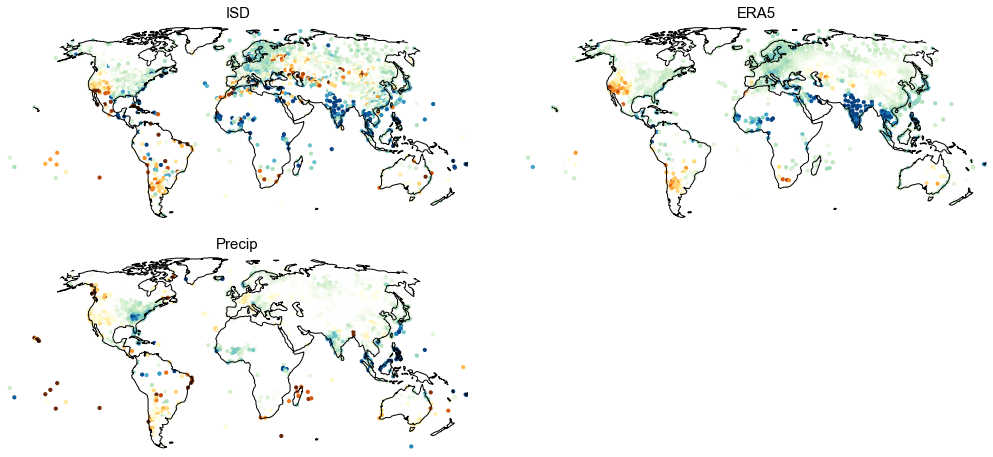

In [25]:
#---checking the sampling has worked ok.

fig = plt.figure(figsize=(16,16))

ax = mymaps.contourmap_continentsonly_robinson_noborder_scatter_pos(fig, datisd.isd, datisd.lons, datisd.lats, 0.2, -2, 2,'ISD',
                                                                    0.05,0.45,0.8,0.97, cmap='precip')

ax = mymaps.contourmap_continentsonly_robinson_noborder_scatter_pos(fig, datisd.era5, datisd.lons, datisd.lats, 0.2, -2, 2,'ERA5',
                                                                    0.5,0.9,0.8,0.97, cmap='precip')

ax = mymaps.contourmap_continentsonly_robinson_noborder_scatter_pos(fig, datisd.pr, datisd.lons, datisd.lats, 0.1,-1,1,'Precip',
                                                                    0.05,0.45,0.6,0.77, cmap='precip')

In [26]:
datisd_arid = datisd.where( (datisd.aridity > 0.05) & (datisd.aridity < 0.5), drop=True)

In [27]:
datisd_zeropr = datisd_arid.where( (datisd_arid.pr > -0.05) & (datisd_arid.pr < 0.05), drop=True)

#-----ERA5 sampled as isd
weights = np.cos(np.deg2rad(datisd_arid.lats))
kernel = stats.gaussian_kde(datisd_arid.era5, weights=weights)
era5asisd_arid_1dpdf = kernel(vpbins)*100.*bsizevp

weights = np.cos(np.deg2rad(datisd_zeropr.lats))
kernel = stats.gaussian_kde(datisd_zeropr.era5, weights=weights)
era5asisd_0pr_1dpdf = kernel(vpbins)*100.*bsizevp

weights = np.cos(np.deg2rad(datisd_arid.lats))
kernel = stats.gaussian_kde(datisd_arid.isd, weights=weights)
isd_arid_1dpdf = kernel(vpbins)*100.*bsizevp

weights = np.cos(np.deg2rad(datisd_zeropr.lats))
kernel = stats.gaussian_kde(datisd_zeropr.isd, weights=weights)
isd_0pr_1dpdf = kernel(vpbins)*100.*bsizevp

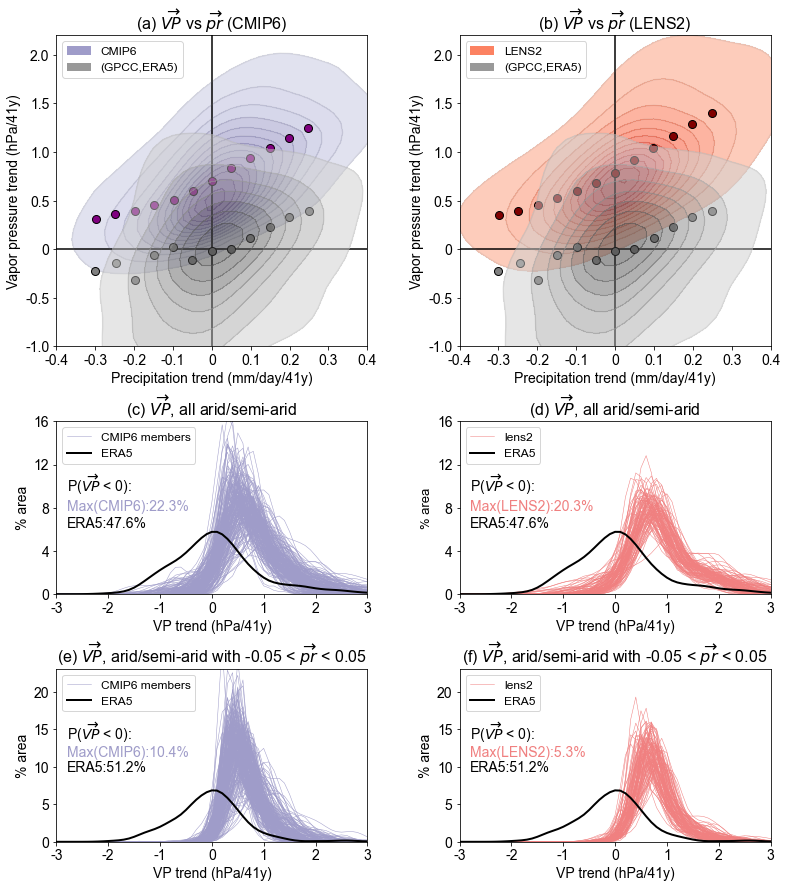

In [28]:
fig = plt.figure(figsize=(16,16))

#-------Panel a
ax = setup_vp_vs_pr(0.05,0.32,0.73,1,'(a) $\overrightarrow{VP}$ vs $\overrightarrow{pr}$ (CMIP6)')


cmin=0.2 ; cmax=3.4 ; ci=0.2
ncontours = (cmax - cmin)/ci + 1

colors = plt.cm.Greys(np.linspace(0.3,1,np.int(ncontours+1-6)))
cmap = mpl.colors.ListedColormap(colors)
ax.contourf(x, y, zgpcc, cmap=cmap, levels=np.arange(cmin, cmax-6*ci, ci), alpha=0.5, zorder=10, label='(GPCP, ERA5)')
ax.contour(x, y, zgpcc, levels=np.arange(cmin, cmax, ci), colors='gray', alpha=0.15, zorder=11)
obslegend = Rectangle((0.95,0.95),5,3,facecolor=colors[3])

cmin=0.2 ; cmax=3.6 ; ci=0.2
ncontours = (cmax - cmin)/ci + 1

colors = plt.cm.Purples(np.linspace(0.3,1,np.int(ncontours)+1))
cmipcolors=colors
cmap = mpl.colors.ListedColormap(colors)
ax.contourf(x, y, zcmip6_weighted.mean('model'), cmap=cmap, levels=np.arange(cmin, cmax, ci), alpha=0.6, label='(CMIP6,CMIP6)')
ax.contour(x, y, zcmip6_weighted.mean('model'), levels=np.arange(cmin, cmax, ci), colors='gray', alpha=0.15)
cmiplegend = Rectangle((0.95,0.95),5,3,facecolor=colors[5])

plt.plot(pr_obs, q_obs, "o", markeredgecolor='black', markerfacecolor='gray', markersize=8)
plt.plot(pr_cmip6.mean('model'), q_cmip6.mean('model'),"o", markeredgecolor='black', markerfacecolor='purple', markersize=8)


legendparts = [cmiplegend, obslegend]
legendlabels = ['CMIP6','(GPCC,ERA5)']
ax.legend(legendparts, legendlabels, loc='upper left', prop={'size': 12})
#---------------


#--------Panel c
ax = fig.add_axes([0.05,0.515,0.27,0.15])
ax.set_xlim(-3,3)
ax.set_title('(c) $\overrightarrow{VP}$, all arid/semi-arid', fontsize=16)
ax.set_xticks([-3,-2,-1,0,1,2,3])
ax.set_xticklabels(['-3','-2','-1','0','1','2','3'], fontsize=14)
ax.set_ylim(0,16)
ax.set_yticks([0,4,8,12,16])
ax.set_yticklabels(['0','4','8','12','16'], fontsize=14)
ax.set_ylabel('% area', fontsize=14)
ax.set_xlabel('VP trend (hPa/41y)', fontsize=14)

for imem in np.arange(0,cmip6vp_arid_allmem.z.size,1):
    ax.plot(vpbins, cmip6_arid_1dpdf[imem,:], color=cmipcolors[5], linewidth=0.5, label='CMIP6 members' if imem == 0 else "")
ax.plot(vpbins, era5_arid_1dpdf, color='black', linewidth=2, label='ERA5')
#ax.plot(vpbins, isd_arid_1dpdf, color='gray', linewidth=2, label='ISD')
#ax.plot(vpbins, era5asisd_arid_1dpdf, color='gray', linestyle='dotted', linewidth=2, label='ERA5 as ISD')

ax.legend(loc='upper left', prop={'size': 12})

ax.text(-2.8,9,'P($\overrightarrow{VP}$ < 0):', ha='left', va='bottom', fontsize=14)
ax.text(-2.8,7.5,'Max(CMIP6):'+"{0:.1f}".format(np.max(plt0_cmip6_arid))+"%", ha='left', va='bottom', fontsize=14, color=cmipcolors[5])
ax.text(-2.8,5.9,'ERA5:'+"{0:.1f}".format(plt0_era5_arid.values)+'%', ha='left', va='bottom', fontsize=14)

#-----------------

#--------Panel e
ax = fig.add_axes([0.05,0.3,0.27,0.15])
ax.set_xlim(-3,3)
ax.set_ylim(0,23)
ax.set_title('(e) $\overrightarrow{VP}$, arid/semi-arid with -0.05 < $\overrightarrow{pr}$ < 0.05', fontsize=16)
ax.set_xticks([-3,-2,-1,0,1,2,3])
ax.set_xticklabels(['-3','-2','-1','0','1','2','3'], fontsize=14)
ax.set_yticks([0,5,10,15,20])
ax.set_yticklabels(['0','5','10','15','20'], fontsize=14)
ax.set_ylabel('% area', fontsize=14)
ax.set_xlabel('VP trend (hPa/41y)', fontsize=14)


for imem in np.arange(0,cmip6vp_arid_allmem.z.size,1):
    ax.plot(vpbins, cmip6_0pr_1dpdf[imem,:], color=cmipcolors[5], linewidth=0.5, label='CMIP6 members' if imem == 0 else "")
ax.plot(vpbins, era5_0pr_1dpdf, color='black', linewidth=2, label='ERA5')
#ax.plot(vpbins, isd_0pr_1dpdf, color='gray', linewidth=2, label='ISD')
#ax.plot(vpbins, era5asisd_0pr_1dpdf, color='gray', linestyle='dotted', linewidth=2, label='ERA5 as ISD')

ax.legend(loc='upper left', prop={'size': 12})


ax.text(-2.8,13,'P($\overrightarrow{VP}$ < 0):', ha='left', va='bottom', fontsize=14)
ax.text(-2.8,11,'Max(CMIP6):'+"{0:.1f}".format(np.max(plt0_cmip6_0pr))+"%", ha='left', va='bottom', fontsize=14, color=cmipcolors[5])
ax.text(-2.8,9,'ERA5:'+"{0:.1f}".format(plt0_era5_0pr.values)+'%', ha='left', va='bottom', fontsize=14)
#------------------


#--------------Panel b
ax = setup_vp_vs_pr(0.4,0.67,0.73,1,'(b) $\overrightarrow{VP}$ vs $\overrightarrow{pr}$ (LENS2)')

cmin=0.2 ; cmax=3.4 ; ci=0.2
ncontours = (cmax - cmin)/ci + 1
colors = plt.cm.Greys(np.linspace(0.3,1,np.int(ncontours+1-6)))
cmap = mpl.colors.ListedColormap(colors)
ax.contourf(x, y, zgpcc, cmap=cmap, levels=np.arange(cmin, cmax-6*ci, ci), alpha=0.5, zorder=10, label='(GPCP, ERA5)')
ax.contour(x, y, zgpcc, levels=np.arange(cmin, cmax, ci), colors='gray', alpha=0.15, zorder=11)
obslegend = Rectangle((0.95,0.95),5,3,facecolor=colors[3])

colors = plt.cm.Reds(np.linspace(0.3,1,np.int(ncontours)+1))
cmap = mpl.colors.ListedColormap(colors)
ax.contourf(x, y, zlens2_weighted.mean('M'), cmap=cmap, levels=np.arange(cmin, cmax, ci), alpha=0.6, label='(CMIP6,CMIP6)')
ax.contour(x, y, zlens2_weighted.mean('M'), levels=np.arange(cmin, cmax, ci), colors='gray', alpha=0.15)
lenslegend = Rectangle((0.95,0.95),5,3,facecolor=colors[3])

plt.plot(pr_obs, q_obs, "o", markeredgecolor='black', markerfacecolor='gray', markersize=8)
plt.plot(pr_lens2.mean('M'), q_lens2.mean('M'),"o", markeredgecolor='black', markerfacecolor='maroon', markersize=8)


legendparts = [lenslegend, obslegend]
legendlabels = ['LENS2','(GPCC,ERA5)']
ax.legend(legendparts, legendlabels, loc='upper left', prop={'size': 12})
#---------------



#-----------panel d
ax = fig.add_axes([0.4,0.515,0.27,0.15])
ax.set_xlim(-3,3)
ax.set_title('(d) $\overrightarrow{VP}$, all arid/semi-arid', fontsize=16)
ax.set_xticks([-3,-2,-1,0,1,2,3])
ax.set_xticklabels(['-3','-2','-1','0','1','2','3'], fontsize=14)
ax.set_ylim(0,16)
ax.set_yticks([0,4,8,12,16])
ax.set_yticklabels(['0','4','8','12','16'], fontsize=14)
ax.set_ylabel('% area', fontsize=13)
ax.set_xlabel('VP trend (hPa/41y)', fontsize=14)

for imem in np.arange(0,lens2vp_arid.member.size,1):
    ax.plot(vpbins, lens2_arid_1dpdf[imem,:], color='lightcoral', linewidth=0.5, label='lens2' if imem == 0 else "")
ax.plot(vpbins, era5_arid_1dpdf, color='black', linewidth=2, label='ERA5')
ax.legend(loc = 'upper left', prop={'size':12})

ax.text(-2.8,9,'P($\overrightarrow{VP}$ < 0):', ha='left', va='bottom', fontsize=14)
ax.text(-2.8,7.5,'Max(LENS2):'+"{0:.1f}".format(np.max(plt0_lens2_arid))+"%", ha='left', va='bottom', fontsize=14, color='lightcoral')
ax.text(-2.8,5.9,'ERA5:'+"{0:.1f}".format(plt0_era5_arid.values)+'%', ha='left', va='bottom', fontsize=14)

#------------------

#----------panel f
ax = fig.add_axes([0.4,0.3,0.27,0.15])
ax.set_xlim(-3,3)
ax.set_ylim(0,23)
ax.set_title('(f) $\overrightarrow{VP}$, arid/semi-arid with -0.05 < $\overrightarrow{pr}$ < 0.05', fontsize=16)
ax.set_xticks([-3,-2,-1,0,1,2,3])
ax.set_xticklabels(['-3','-2','-1','0','1','2','3'], fontsize=14)
ax.set_yticks([0,5,10,15,20])
ax.set_yticklabels(['0','5','10','15','20'], fontsize=14)
ax.set_ylabel('% area', fontsize=14)
ax.set_xlabel('VP trend (hPa/41y)', fontsize=14)

for imem in np.arange(0,lens2vp_arid.member.size,1):
    ax.plot(vpbins, lens2_0pr_1dpdf[imem,:], color='lightcoral', linewidth=0.5, label='lens2' if imem == 0 else "")
ax.plot(vpbins, era5_0pr_1dpdf, color='black', linewidth=2, label='ERA5')

ax.legend(loc = 'upper left', prop={'size':12})

ax.text(-2.8,13,'P($\overrightarrow{VP}$ < 0):', ha='left', va='bottom', fontsize=14)
ax.text(-2.8,11,'Max(LENS2):'+"{0:.1f}".format(np.max(plt0_lens2_0pr))+"%", ha='left', va='bottom', fontsize=14, color='lightcoral')
ax.text(-2.8,9,'ERA5:'+"{0:.1f}".format(plt0_era5_0pr.values)+'%', ha='left', va='bottom', fontsize=14)

fig.savefig(plotpath+'figS17.pdf', bbox_inches='tight', facecolor='white')